In [1]:
# Copyright 2011-2019 Kwant authors.
#
# This file is part of Kwant.  It is subject to the license terms in the file
# LICENSE.rst found in the top-level directory of this distribution and at
# http://kwant-project.org/license.  A list of Kwant authors can be found in
# the file AUTHORS.rst at the top-level directory of this distribution and at
# http://kwant-project.org/authors.

from packaging import version

import numpy as np
import scipy.linalg
import scipy.optimize
import scipy.sparse as sp

__all__ = ["find_boundstates"]

# TODO: remove this when we depend on scipy > 1.1
#1.3.1 here
if version.parse(scipy.__version__) > version.parse("1.1"):
    null_space = scipy.linalg.null_space
else:

    def null_space(A, rcond=None):
        u, s, vh = scipy.linalg.svd(A, full_matrices=True)
        M, N = u.shape[0], vh.shape[1]
        if rcond is None:
            rcond = np.finfo(s.dtype).eps * max(M, N)
        tol = np.amax(s) * rcond
        num = np.sum(s > tol, dtype=int)
        Q = vh[num:, :].T.conj()
        return Q


# If available, use MUMPS support for shift-inverse sparse diagonalization
# Can import mumps alright.
try:
    from kwant.linalg import mumps
except ImportError:
    sparse_diag = sp.linalg.eigsh
else:

    class _LuInv(sp.linalg.LinearOperator):
        def __init__(self, A):
            inst = mumps.MUMPSContext()
            inst.analyze(A)
            inst.factor(A)
            self.solve = inst.solve
            super().__init__(A.dtype, A.shape)

        def _matvec(self, x):
            return self.solve(x.astype(self.dtype))

    def sparse_diag(matrix, k, sigma, **kwargs):
        if sigma == 0:
            shifted_matrix = matrix
        else:
            shifted_matrix = matrix - sigma * sp.identity(matrix.shape[0])
        return sp.linalg.eigsh(matrix, k, sigma=sigma, OPinv=_LuInv(shifted_matrix),
                               **kwargs)

"""syst: kwant.system.FiniteSystem
"""

def find_boundstates(
    syst,
    min_energy,
    max_energy,
    params=None,
    sparse=True,
    check_hermiticity=True,
    rtol=1e-3,
):
    """Return boundstates of an open system in an energy window

    Parameters
    ----------
    syst : kwant.system.FiniteSystem
        Must have leads.
    min_energy, max_energy : float
        The lower and upper bounds in energy to search for boundstates.
    params : dict, optional
        The keyword arguments to 'syst'.
    sparse : bool, default: True
        If True use sparse linear algebra, otherwise use dense.
    check_hermiticity : bool, default: True
        If True, checks the Hermiticity of the system Hamiltonian
    rtol : float, default: 1E-3
        boundstates that are closer together than
        'rtol * (max_energy - min_energy)' may be missed.

    Returns
    -------
    energies : 1D float array
        The energies of the bound states.
    wavefunctions : 2D complex array
        The columns are the bound state wavefunctions defined
        over the scattering region.
    """

    # TODO: apply lru_cache to this once
    # https://github.com/scipy/scipy/issues/10846 is solved.
    def min_eigenvalue(energy):
        H_eff = make_linsys(
            syst,
            energy,
            params=params,
            sparse=sparse,
            check_hermiticity=check_hermiticity,
        )
        try:
            if sparse:
                if H_eff.shape[0] <= 2:
                    raise ValueError(
                        "The system is too small to use sparse diagonalization. "
                        "Try setting 'sparse=False'."
                    )
                vals = sparse_diag(
                    H_eff.tocsc(), k=1, sigma=0, which="LM", return_eigenvectors=False
                )
                return vals[0]
            else:
                vals = np.linalg.eigvalsh(H_eff)
                which = np.argmin(np.abs(vals))
                return vals[which]
        except RuntimeError:  # Some problem diagonalizing
            return np.inf

    if syst.site_ranges is not None:
        tot_norbs = syst.site_ranges[-1][-1]
    else:
        _, norbs = syst.hamiltonian_submatrix(params=params, return_norb=True)[:2]
        tot_norbs = sum(norbs)

    # Grid the energy window and search for roots in the sub-windows
    # where the min-eigenvalue changes sign. These will either be
    # true roots or discontinuities. Note that if there are >1 roots
    # in the same sub-window then at least one of them will be missed.
    energies = np.linspace(
        min_energy, max_energy, int((max_energy - min_energy) / rtol)
    )
    intervals = zip(energies, energies[1:])
    candidates = []
    for a, b in intervals:
        if np.sign(min_eigenvalue(a)) != np.sign(min_eigenvalue(b)):
            candidate = scipy.optimize.brentq(min_eigenvalue, a, b)
            candidates.append(candidate)

    # Check which candidate points give actual boundstates.
    energies = []
    states = []
    for energy in candidates:
        vecs = extract_boundstates(syst, energy, params=params, sparse=sparse)
        # vecs.shape[1] == 0 if there were no boundstates found
        energies.append([energy] * vecs.shape[1])
        # Here we discard the mode part of the solution just to
        # make the output format more uniform (wavefunction has
        # same number of components at all energies).
        states.append(vecs[:tot_norbs, :])

    if not energies:
        return np.empty((0,)), np.empty((tot_norbs, 0))
    else:
        return np.hstack(energies), np.hstack(states)


def extract_boundstates(
    syst, energy=0, params=None, sparse=True, check_hermiticity=True, tol=1e-8
):
    """Return any true boundstates of 'syst' at 'energy'

    Params
    ------
    syst : kwant.FiniteSystem
        Must have leads
    energy : float
    params : dict, optional
        Keyword arguments to 'syst'
    sparse : bool, default: True
        If True, returns sparse matrices
    check_hermiticity : bool, default: True
        If True, check the system Hamiltonian for hermiticity

    Returns
    -------
    vecs : 2D array
        The columns are bound state wavefunctions.
        The first N rows is in the tight-binding basis of the
        scattering region, and the remaining rows are in the
        basis of stabilized evanescent modes of the leads.

    Notes
    -----
    We diagonalize the linear system returned by 'make_linsys', and
    search for zero eigenvalues. We then look for vectors in the basis
    of zero-eigenvalue eigenvectors that satisfy the bound state condition,
    eq. 19 of https://doi.org/10.21468/SciPostPhys.4.5.026.
    """

    lhs, T = make_linsys(
        syst,
        energy,
        params=params,
        sparse=sparse,
        check_hermiticity=check_hermiticity,
        return_validation=True,
        which="hermitian",
    )

    if sparse:
        if lhs.shape[0] <= 2:
            raise ValueError(
                "The system is too small to use sparse diagonalization. "
                "Try setting 'sparse=False'."
            )
        k = min(6, lhs.shape[0] - 2)  # 6 is the default for sp.linalg.eigsh
        try_again = True
        # Solve the eigenproblem with successively large values of 'k' until
        # we get all the zero eigenvalues. (In most cases this loop will
        # run once).
        while try_again:
            vals, vecs = sparse_diag(lhs.tocsc(), k=k, sigma=0, which="LM")
            zeros = np.abs(vals) < tol  # TODO: make this check better
            if not np.all(zeros):  # we have found all the zero eigenvalues
                try_again = False
            else:
                k *= 2  # try again with twice the number of eigenvalues
                if k >= lhs.shape[0] - 1:
                    raise ValueError(
                        "More eigenvalues are 0 than can be obtained by "
                        "sparse diagonalization. Try setting 'sparse=False'."
                    )
    else:
        vals, vecs = np.linalg.eigh(lhs)
        zeros = np.abs(vals) < tol  # TODO make this check better

    if not np.any(zeros):
        return np.empty((lhs.shape[0], 0))


    zero_vecs = vecs[:, zeros]
    # To find the true boundstates we find the null space of the operator
    # in eq 19 (T) in the basis of zero-eigenvalue vectors.
    p = T @ zero_vecs
    if np.allclose(p, 0):
        # 'zero_vecs' are already a basis for the null space of T
        return zero_vecs
    else:
        # TODO: not sure about this value for 'rcond', we need to ensure
        #       that rcond is sufficiently large in the case that p is
        #       zero (i.e. zero_vecs are individually boundstates).
        bound_states = null_space(p, rcond=tol / np.max(np.abs(p)))
        # transform back to original basis
        # TODO: rotate the basis so the bound states have the correct symmetries
        return np.asarray(zero_vecs @ bound_states)


def make_linsys(
    syst,
    energy=0,
    params=None,
    sparse=True,
    check_hermiticity=True,
    return_validation=False,
    which="hermitian",
):
    """Return the linear system for finding boundstates

    Returns ether the linear system defined in equation 12 or equation 11
    of https://doi.org/10.21468/SciPostPhys.4.5.026, and the linear
    operator defined in equation 19 of the same article.

    Params
    ------
    syst : kwant.FiniteSystem
        Must have leads
    energy : float
    params : dict, optional
        Keyword arguments to 'syst'
    sparse : bool, default: True
        If True, returns sparse matrices
    check_hermiticity : bool, default: True
        If True, check the system Hamiltonian for hermiticity
    return_validation: bool, default: False
        If True, also return the linear operator used for
        checking for true bound states (equation 19 of the article).
    which : str, default: "hermitian"
        Which linear system to return. If "hermitian" returns the
        linear system defined in equation 12, if "svd" returns
        the linear system defined in equation 11.

    Returns
    -------
    lhs : 2D array or sparse matrix
        The linear system for finding boundstates
    T : 2D array or sparse matrix
        A linear operator for checking bound states.
        zero-eigenvalue eigenvectors of 'lhs' that are in the
        null-space of 'T' are true bound states. Only returned
        if 'return_validation' is True.
    """
    if not syst.leads:
        raise ValueError("'syst' must have leads attached")
    if any(interface.shape[0] == 0 for interface in syst.lead_interfaces):
        raise ValueError(
            "All the leads of 'syst' must have non-zero " "inter-cell hopping"
        )

    lhs, norb = syst.hamiltonian_submatrix(
        params=params, sparse=sparse, return_norb=True
    )[:2]
    offsets = np.empty(norb.shape[0] + 1, int)
    offsets[0] = 0
    offsets[1:] = np.cumsum(norb)
    scattering_region_norbs = offsets[-1]

    if check_hermiticity and len(lhs.data):
        rtol = 1e-13
        atol = 1e-300
        tol = rtol * np.max(np.abs(lhs.data)) + atol
        if np.any(np.abs((lhs - lhs.T.conj()).data) > tol):
            raise ValueError(
                "System Hamiltonian is not Hermitian. "
                "Use option `check_hermiticity=False` "
                "if this is intentional."
            )

    if sparse:
        lhs = lhs - energy * sp.identity(lhs.shape[0])
    else:
        lhs.flat[:: (offsets[-1] + 1)] -= energy

    phi_e = []
    svd_vs = []
    transfs = []
    for leadnum, interface in enumerate(syst.lead_interfaces):
        lead = syst.leads[leadnum]
        _, stab = lead.modes(energy, params=params)
        svd_v = stab.sqrt_hop
        # Evanescent modes (schur vectors) are stored after
        # the 2*nmodes propagating (in/out) modes
        evan_vecs = slice(2 * stab.nmodes, None)
        u_out = stab.vecs[:, evan_vecs]
        ulinv_out = stab.vecslmbdainv[:, evan_vecs]

        # Construct a matrix of 1's that translates the
        # inter-cell hopping to a proper hopping
        # from the system to the lead.
        iface_orbs = np.r_[tuple(slice(offsets[i], offsets[i + 1]) for i in interface)]

        n_lead_orbs = svd_v.shape[0]
        if n_lead_orbs != len(iface_orbs):
            msg = (
                "Lead {0} has hopping with dimensions "
                "incompatible with its interface dimension."
            )
            raise ValueError(msg.format(leadnum))

        coords = np.r_[[np.arange(len(iface_orbs))], [iface_orbs]]
        transf = sp.csc_matrix(
            (np.ones(len(iface_orbs)), coords), shape=(iface_orbs.size, lhs.shape[0])
        )

        phi_e.append(ulinv_out)
        svd_vs.append(svd_v)
        # We are saving these for use in '_validation_operator', where we
        # expect each projector to project *from the scattering region only*,
        # hence the slice up to 'scattering_region_norbs'
        transfs.append(transf[:, :scattering_region_norbs])

        if which == "hermitian":
            A, B, C = _hermitian_matrices(svd_v, transf, u_out, ulinv_out)
        elif which == "svd":
            A, B, C = _svd_matrices(svd_v, transf, u_out, ulinv_out)
        else:
            raise ValueError("'which' must be 'hermitian' or 'svd'")

        if sparse:
            A = sp.csc_matrix(A)
            B = sp.csc_matrix(B)
            C = sp.csc_matrix(C)
            lhs = sp.bmat([[lhs, A], [B, C]])
        else:
            lhs = np.block([[lhs, A], [B, C]])

    if return_validation:
        return (
            lhs,
            _validation_operator(
                phi_e=phi_e,
                svd_vs=svd_vs,
                transfs=transfs,
                orb_offsets=offsets,
                sparse=sparse,
            ),
        )
    else:
        return lhs


# Equation 12
def _hermitian_matrices(svd_v, transf, u_out, ulinv_out):
    A = transf.T @ svd_v @ u_out
    B = A.conj().T
    C = -u_out.T.conj() @ ulinv_out
    return A, B, C


# Equation 11
def _svd_matrices(svd_v, transf, u_out, ulinv_out):
    A = transf.T @ svd_v @ u_out
    B = svd_v.conj().T @ transf
    C = -ulinv_out
    return A, B, C


# Equation 19
def _validation_operator(phi_e, svd_vs, transfs, orb_offsets, sparse):

    syst_size = orb_offsets[-1]
    mode_size = sum(phi.shape[1] for phi in phi_e)
    sol_size = syst_size + mode_size

    p_psi = sp.csc_matrix(
        (np.ones(syst_size), (np.arange(syst_size),) * 2), shape=(syst_size, sol_size)
    )
    p_q = sp.csc_matrix(
        (np.ones(mode_size), (np.arange(mode_size), np.arange(syst_size, sol_size))),
        shape=(mode_size, sol_size),
    )

    svd_v = np.vstack(svd_vs)
    transf = sp.vstack(transfs)
    # The states are the *columns*, so use hstack rather than vstack
    phi = np.hstack(phi_e)

    r = svd_v.conj().T @ (transf @ p_psi) - phi @ p_q

    if sparse:
        r = sp.csc_matrix(r)

    return r


## My code

In [2]:
import kwant
import tinyarray
import numpy as np
from matplotlib import pyplot as plt

# For plotting
from matplotlib import pyplot


a = 1 # angstroms

norbs = 4 # N_t = 4

lat = kwant.lattice.chain(a, norbs=4)

tau_x = tinyarray.array([[0, 1], [1, 0]])
tau_y = tinyarray.array([[0, -1j], [1j, 0]])
tau_z = tinyarray.array([[1, 0], [0, -1]])

In [3]:
def complex_round(num):
    return np.around(num.real, 2) + np.around(num.imag, 2) * 1j

trial_array = [[1.31291411293123189631826481679-1.934813481793812739183791371923879477149871j]*4]*4
trial_array = np.array(trial_array)
print(complex_round(1.31291411293123189631826481679-1.934813481793812739183791371923879477149871j))
print(trial_array.real)
complex_round(trial_array)

(1.31-1.93j)
[[1.31291411 1.31291411 1.31291411 1.31291411]
 [1.31291411 1.31291411 1.31291411 1.31291411]
 [1.31291411 1.31291411 1.31291411 1.31291411]
 [1.31291411 1.31291411 1.31291411 1.31291411]]


array([[1.31-1.93j, 1.31-1.93j, 1.31-1.93j, 1.31-1.93j],
       [1.31-1.93j, 1.31-1.93j, 1.31-1.93j, 1.31-1.93j],
       [1.31-1.93j, 1.31-1.93j, 1.31-1.93j, 1.31-1.93j],
       [1.31-1.93j, 1.31-1.93j, 1.31-1.93j, 1.31-1.93j]])

In [4]:
hamil = ("kron(sigma_z, sigma_0) * (mu - 2*t) + "
                  "kron(sigma_0, sigma_z) * B + "
                  "kron(sigma_x, sigma_0) * delta + "
                  "kron(sigma_z, sigma_0) * t * (1-k_x**2) + "
                  "kron(sigma_z, sigma_0) * kron(sigma_0, sigma_x) *alpha_so * k_x")
#print(kwant.continuum.sympify(hamil))
#print(sp.sympify("tau_z * (mu - 2*t) + sigma_z * B + tau_x * delta + tau_z * t * cos(k) + tau_z * sigma_x *alpha_so * sin(k)"))
hamil = kwant.continuum.sympify(hamil.format())
#print(kwant.continuum.sympify(hamil))
#print(sp.sympify(hamil))
ham_discretized = kwant.continuum.discretize(hamil, grid=lat)

print('MTI Hamiltonian:', hamil)
print('Discretised MTI Hamiltonian:', ham_discretized)

/var/folders/tq/z3lkw8s95r1g4v3_7b8tv3_w0000gn/T/ipykernel_9850/2795594642.py:8: KwantDeprecationWarning: Accessing kwant.continuum without an explicit import is deprecated. Instead, explicitly 'import kwant.continuum'.
  hamil = kwant.continuum.sympify(hamil.format())


MTI Hamiltonian: Matrix([[B + mu - 2*t + t*(1 - k_x**2), alpha_so*k_x, delta, 0], [alpha_so*k_x, -B + mu - 2*t + t*(1 - k_x**2), 0, delta], [delta, 0, B - mu + 2*t - t*(1 - k_x**2), -alpha_so*k_x], [0, delta, -alpha_so*k_x, -B - mu + 2*t - t*(1 - k_x**2)]])
Discretised MTI Hamiltonian: # Discrete coordinates: x

# Onsite element:
_cache_0 = (
array([[ 1.+0.j,  0.+0.j,  0.+0.j,  0.+0.j],
       [ 0.+0.j, -1.+0.j,  0.+0.j,  0.+0.j],
       [ 0.+0.j,  0.+0.j,  1.+0.j,  0.+0.j],
       [ 0.+0.j,  0.+0.j,  0.+0.j, -1.+0.j]]))
_cache_1 = (
array([[ 1.+0.j,  0.+0.j,  0.+0.j,  0.+0.j],
       [ 0.+0.j,  1.+0.j,  0.+0.j,  0.+0.j],
       [ 0.+0.j,  0.+0.j, -1.+0.j,  0.+0.j],
       [ 0.+0.j,  0.+0.j,  0.+0.j, -1.+0.j]]))
_cache_2 = (
array([[-3.+0.j,  0.+0.j,  0.+0.j,  0.+0.j],
       [ 0.+0.j, -3.+0.j,  0.+0.j,  0.+0.j],
       [ 0.+0.j,  0.+0.j,  3.+0.j,  0.+0.j],
       [ 0.+0.j,  0.+0.j,  0.+0.j,  3.+0.j]]))
_cache_3 = (
array([[0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.

/Users/afasjasd/anaconda3/envs/snakes/lib/python3.9/site-packages/sympy/__init__.py:672: SymPyDeprecationWarning: 

importing sympy.matrices.matrices with 'from sympy import *' has been
deprecated since SymPy 1.6. Use import sympy.matrices.matrices
instead. See https://github.com/sympy/sympy/issues/18245 for more
info.

  self.Warn(
/Users/afasjasd/anaconda3/envs/snakes/lib/python3.9/site-packages/sympy/__init__.py:672: SymPyDeprecationWarning: 

importing sympy.matrices.matrices with 'from sympy import *' has been
deprecated since SymPy 1.6. Use import sympy.matrices.matrices
instead. See https://github.com/sympy/sympy/issues/18245 for more
info.

  self.Warn(


## Try Direct subs

In [148]:
syst = kwant.Builder()
[x] = lat(20).pos
print(x)
print(tinyarray.array([-a, 0]).ndim)
print(np.array((-a, 0)).ndim)
kwant.Builder(kwant.TranslationalSymmetry([-a]))
print(kwant.continuum.sympify('cos(k_x)**2.+sin(k_x)**2.'))
sp.sympify('cos(k_x)**2.+sin(k_x)**2.')

200.0
1
1
sin(k_x)**2.0 + cos(k_x)**2.0


sin(k_x)**2.0 + cos(k_x)**2.0

In [5]:
def make_system(a=1, W=10, L=10,
                mu=0.4, Delta=0.1, Deltapos=4, t=1.0):
    # Start with an empty tight-binding system. On each site, there
    # are now electron and hole orbitals, so we must specify the
    # number of orbitals per site. The orbital structure is the same
    # as in the Hamiltonian.
    # norbs=4 as per the scipost paper
    lat = kwant.lattice.chain(norbs=4)
    syst = kwant.Builder()
    
    tau_x = np.kron(np.array([[0, 1], [1, 0]]), np.eye(2))
    tau_y = np.kron(np.array([[0, -1j], [1j, 0]]), np.eye(2))
    tau_z = np.kron(np.array([[1, 0], [0, -1]]), np.eye(2))
    sigma_x = np.kron(np.eye(2), np.array([[0, 1], [1, 0]]))
    sigma_y = np.kron(np.eye(2), np.array([[0, -1j], [1j, 0]]))
    sigma_z = np.kron(np.eye(2), np.array([[1, 0], [0, -1]]))

    #### Define the scattering region. ####
    # The superconducting order parameter couples electron and hole orbitals
    # on each site, and hence enters as an onsite potential.
    # The pairing is only included beyond the point 'Deltapos' in the scattering region.
    syst[(lat(x) for x in range(L))] = (mu-2.*t)*tau_z + B*sigma_z


    # Hoppings
    syst[lat.neighbors()] = -t * tau_z
    #### Define the leads. ####
    # Left lead - normal, so the order parameter is zero.
    sym_left = kwant.TranslationalSymmetry((-a, 0))
    # Specify the conservation law used to treat electrons and holes separately.
    # We only do this in the left lead, where the pairing is zero.
    lead0 = kwant.Builder(sym_left, conservation_law=-tau_z, particle_hole=tau_y)
    lead0[(lat(0, j) for j in range(W))] = (4 * t - mu) * tau_z
    lead0[lat.neighbors()] = -t * tau_z
    # Right lead - superconducting, so the order parameter is included.
    sym_right = kwant.TranslationalSymmetry((a, 0))
    lead1 = kwant.Builder(sym_right)
    lead1[(lat(0, j) for j in range(W))] = (4 * t - mu) * tau_z + Delta * tau_x
    lead1[lat.neighbors()] = -t * tau_z

    #### Attach the leads and return the system. ####
    syst.attach_lead(lead0)
    syst.attach_lead(lead1)

    return syst

In [6]:
def make_system(mu=0.5,
                t=-1., B=1., delta=0.5, alpha_so=0.5, V_N=1.25, phi=0, L=5):
    # Start with an empty tight-binding system. On each site, there
    # are now electron and hole orbitals, so we must specify the
    # number of orbitals per site. The orbital structure is the same
    # as in the Hamiltonian.
    # norbs=4 as per the scipost paper
    lat = kwant.lattice.chain(norbs=4)
    syst = kwant.Builder()
    
    tau_x = np.kron(np.array([[0, 1], [1, 0]]), np.eye(2))
    tau_y = np.kron(np.array([[0, -1j], [1j, 0]]), np.eye(2))
    tau_z = np.kron(np.array([[1, 0], [0, -1]]), np.eye(2))
    sigma_x = np.kron(np.eye(2), np.array([[0, 1], [1, 0]]))
    sigma_y = np.kron(np.eye(2), np.array([[0, -1j], [1j, 0]]))
    sigma_z = np.kron(np.eye(2), np.array([[1, 0], [0, -1]]))

    #### Define the scattering region. ####
    # The superconducting order parameter couples electron and hole orbitals
    # on each site, and hence enters as an onsite potential.
    # The pairing is only included beyond the point 'Deltapos' in the scattering region.
    syst[(lat(x) for x in range(L))] = (mu-2.*t+V_N)*tau_z + B*sigma_z


    # Hoppings
    syst[lat.neighbors()] = t*tau_z + alpha_so*1j*np.matmul(tau_z, sigma_x)
    #### Define the leads. ####
    sym_left = kwant.TranslationalSymmetry([-a])
    lead0 = kwant.Builder(sym_left)
    lead0[(lat(-1))] = (mu-2.*t)*tau_z + B*sigma_z + delta*tau_x
    lead0[lat.neighbors()] = t*tau_z + alpha_so*1j*np.matmul(tau_z, sigma_x)
    # Right lead - superconducting, so the order parameter is included.
    sym_right = kwant.TranslationalSymmetry([a])
    lead1 = kwant.Builder(sym_right)
    lead1[(lat(L))] = (mu-2.*t)*tau_z + B*sigma_z + delta*tau_x #phi here on delta?
    lead1[lat.neighbors()] = np.matmul(sp.linalg.expm(phi*1j*tau_z), t*tau_z + alpha_so*1j*np.matmul(tau_z, sigma_x))

    #### Attach the leads and return the system. ####
    syst.attach_lead(lead0)
    syst.attach_lead(lead1)

    return syst

In [7]:
def make_system_alt(mu=0.5,
                t=-1., B=1., delta=0.5, alpha_so=0.5, V_N=1.25, phi=0, L=1):
    # Start with an empty tight-binding system. On each site, there
    # are now electron and hole orbitals, so we must specify the
    # number of orbitals per site. The orbital structure is the same
    # as in the Hamiltonian.
    # norbs=4 as per the scipost paper
    lat = kwant.lattice.chain(norbs=4)
    syst = kwant.Builder()
    
    tau_x = np.kron(np.array([[0, 1], [1, 0]]), np.eye(2))
    tau_y = np.kron(np.array([[0, -1j], [1j, 0]]), np.eye(2))
    tau_z = np.kron(np.array([[1, 0], [0, -1]]), np.eye(2))
    sigma_x = np.kron(np.eye(2), np.array([[0, 1], [1, 0]]))
    sigma_y = np.kron(np.eye(2), np.array([[0, -1j], [1j, 0]]))
    sigma_z = np.kron(np.eye(2), np.array([[1, 0], [0, -1]]))

    #### Define the scattering region. ####
    # The superconducting order parameter couples electron and hole orbitals
    # on each site, and hence enters as an onsite potential.
    # The pairing is only included beyond the point 'Deltapos' in the scattering region.
    syst[(lat(x) for x in range(L))] = (mu-2.*t+V_N)*tau_z + B*sigma_z


    # Hoppings
    syst[lat.neighbors()] = t*tau_z + alpha_so*1j*np.matmul(tau_z, sigma_x)
    #### Define the leads. ####
    sym_left = kwant.TranslationalSymmetry([-a])
    lead0 = kwant.Builder(sym_left)
    lead0[(lat(-1))] = (mu-2.*t)*tau_z + B*sigma_z + delta*tau_x
    lead0[lat.neighbors()] = t*tau_z + alpha_so*1j*np.matmul(tau_z, sigma_x)
    # Right lead - superconducting, so the order parameter is included.
    sym_right = kwant.TranslationalSymmetry([a])
    lead1 = kwant.Builder(sym_right)
    #print((mu-2.*t)*tau_z + B*sigma_z + delta*tau_x)
    #print(complex_round(np.matmul(sp.linalg.expm(phi*1j*tau_z), (mu-2.*t)*tau_z + B*sigma_z + delta*tau_x)))
    lead1[(lat(L))] =  (mu-2.*t)*tau_z + B*sigma_z + np.matmul(sp.linalg.expm(phi*1j*tau_z), delta*tau_x) #phi here on delta?
    lead1[lat.neighbors()] = t*tau_z + alpha_so*1j*np.matmul(tau_z, sigma_x)

    #### Attach the leads and return the system. ####
    syst.attach_lead(lead0)
    syst.attach_lead(lead1)

    return syst

In [192]:
###Declan's vers, don't use

def make_system(L):
    syst = kwant.Builder()
    
    def syst_shape(site):
        [x] = site.pos
        return (0 <= x <= L)

    syst.fill(ham_discretized, syst_shape, [0])
    lead_left = kwant.Builder(kwant.TranslationalSymmetry([-a]))
    lead_right = kwant.Builder(kwant.TranslationalSymmetry([a]))
    
    
    def lead_shape(site):
        return True
    
   
    lead_left.fill(ham_discretized, lead_shape, [0])
    lead_right.fill(ham_discretized, lead_shape, [L])
    
    syst.attach_lead(lead_left) # lead 0
    syst.attach_lead(lead_right) # lead 1
    
    return syst 

syst1 = make_system(0)
finite_syst1 = kwant.builder.FiniteSystem(syst1)

ValueError: Builder symmetry is not a subgroup of the template symmetry

In [166]:
def cos(x):
    return np.cos(x)

def sin(x):
    return np.sin(x)

params_toy = dict(delta=0.5,
                      mu=0.5,
                      alpha_so=0.5,
                      B=1.,
                      t=-1.,
                     )

[[ 0.04298738+0.06614198j  0.07598254-0.06448548j -0.13644209+0.02984751j
   0.14485172+0.20688401j]
 [-0.07943305+0.05162559j -0.21368122+0.0688291j  -0.09808502+0.30806254j
   0.41895848-0.30253747j]
 [-0.05162559-0.07943305j  0.0688291 +0.21368122j  0.30806254+0.09808502j
  -0.30253747-0.41895848j]
 [-0.06614198+0.04298738j -0.06448548-0.07598254j  0.02984751+0.13644209j
   0.20688401-0.14485172j]]


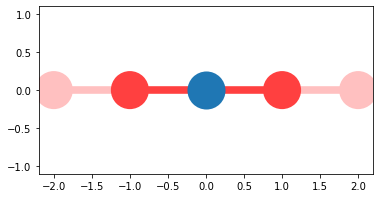

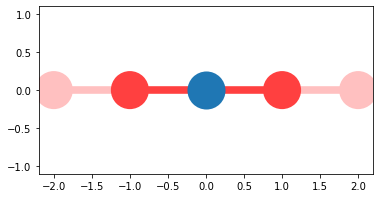

In [9]:
syst3 = make_system_alt(L=1, phi=0.*np.pi, B=1.)
syst3f = syst3.finalized()
print(syst3f.leads[1].modes()[1].vecs)
kwant.plot(syst3f)

[[ 3.5+0.j  0. +0.j  0.5+0.j  0. +0.j]
 [ 0. +0.j  1.5+0.j  0. +0.j  0.5+0.j]
 [ 0.5+0.j  0. +0.j -1.5+0.j  0. +0.j]
 [ 0. +0.j  0.5+0.j  0. +0.j -3.5+0.j]]
[[ 3.5-0.j  0. -0.j  0.5-0.j  0. -0.j]
 [ 0. -0.j  1.5-0.j  0. -0.j  0.5-0.j]
 [ 0.5-0.j  0. -0.j -1.5-0.j  0. -0.j]
 [ 0. -0.j  0.5-0.j  0. -0.j -3.5-0.j]]
True


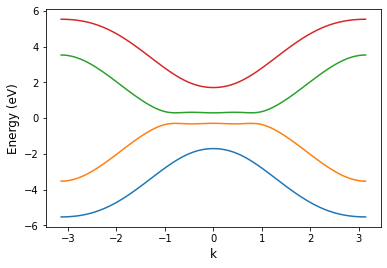

In [10]:
trial_ham = syst3f.leads[1].cell_hamiltonian()
print(trial_ham)
print(trial_ham.T.conj())
print(np.allclose(trial_ham, trial_ham.T.conj()))

bands=kwant.physics.Bands(syst3f.leads[1])
momenta=np.linspace(-np.pi,np.pi,101)
energies=[bands(k) for k in momenta]

x=np.array(energies)
en=(x)
#plt.ylim(-0.5,0.5)


plt.plot(momenta, en)
plt.ylabel('Energy (eV)', fontsize=12)
plt.xlabel('k', fontsize=12)
plt.show()


[[ 0.00844997-0.05880985j  0.14545991+0.32614651j  0.35322723-0.052542j
  -0.05412509+0.02450459j  0.02603216-0.0841298j  -0.01626573+0.00864666j]
 [ 0.02184608+0.02780584j  0.56514408+0.20158764j -0.47365153-0.36834717j
  -0.03279241-0.01323154j  0.17772193+0.05499225j  0.00409315+0.00769985j]
 [-0.08533646+0.5939218j   0.01440337+0.03229487j  0.03497639-0.00520268j
   0.54661032-0.24747236j  0.00257769-0.00833049j  0.16426796-0.08732278j]
 [-0.22062395-0.28081169j  0.05596029+0.01996111j -0.04690074-0.03647356j
   0.33117115+0.13362563j  0.01759794+0.00544531j -0.04133676-0.07776097j]]


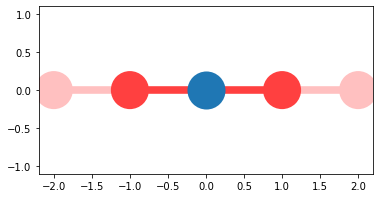

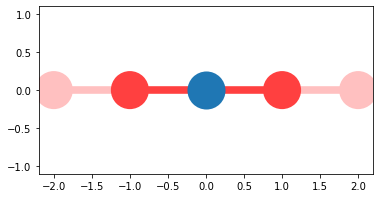

In [11]:
syst2 = make_system(L=1, phi=0.5*np.pi, B=1.)
syst2f = syst2.finalized()
print(syst2f.leads[1].modes()[1].vecs)
kwant.plot(syst2f)

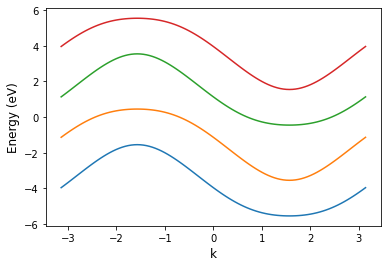

In [12]:
bands=kwant.physics.Bands(syst2f.leads[1])
momenta=np.linspace(-np.pi,np.pi,101)
energies=[bands(k) for k in momenta]

x=np.array(energies)
en=(x)
#plt.ylim(-100,100)


plt.plot(momenta, en)

plt.ylabel('Energy (eV)', fontsize=12)
plt.xlabel('k', fontsize=12)
plt.show()


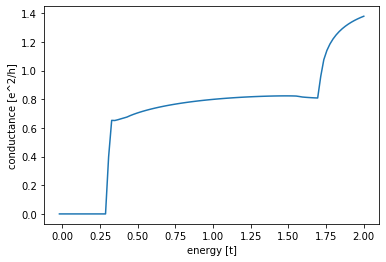

In [512]:

def plot_conductance(syst, energies):
    # Compute conductance
    data = []
    for energy in energies:
        smatrix = kwant.smatrix(syst, energy)
        #print(smatrix)
        #print(smatrix.submatrix((0), (0)).shape[0]-smatrix.transmission((0), (0))+smatrix.transmission((1), (0)))
        # Conductance is N - R_ee + R_he
        data.append(smatrix.transmission(1, 0))
    pyplot.figure()
    pyplot.plot(energies, data)
    pyplot.xlabel("energy [t]")
    pyplot.ylabel("conductance [e^2/h]")
    pyplot.show()
    
plot_conductance(syst2f, energies=[0.002 * i for i in np.linspace(-10, 1000, 100)])

In [658]:
energies, wavefunctions = find_boundstates(syst3f, -0.2, 0.2, rtol=1e-2)
print(energies, wavefunctions)

[] []


In [647]:
def phi_scan(Bv=1., V_Nv=1.25):
    energy_arrays = []
    wavefunc_arrays = []
    for i in np.linspace(0, 4*np.pi, 21):
        syst = make_system_alt(L=1, phi=i, B=Bv, V_N=V_Nv)
        systf = syst.finalized()
        energies, wavefunctions = find_boundstates(systf, -0.2, 0.2, rtol=1e-2)
        energy_arrays.append(energies)
        wavefunc_arrays.append(wavefunctions)
    return energy_arrays, wavefunc_arrays


[array([-0.14242703,  0.14242703]), array([-0.13504377,  0.13504377]), array([-0.11401109,  0.11401109]), array([-0.08212527,  0.08212527]), array([-0.04289821,  0.04289821]), array([-1.71737624e-16, -1.71737624e-16]), array([-0.04289821,  0.04289821]), array([-0.08212527,  0.08212527]), array([-0.11401109,  0.11401109]), array([-0.13504377,  0.13504377]), array([-0.14242703,  0.14242703]), array([-0.13504377,  0.13504377]), array([-0.11401109,  0.11401109]), array([-0.08212527,  0.08212527]), array([-0.04289821,  0.04289821]), array([2.16840434e-16, 2.16840434e-16]), array([-0.04289821,  0.04289821]), array([-0.08212527,  0.08212527]), array([-0.11401109,  0.11401109]), array([-0.13504377,  0.13504377]), array([-0.14242703,  0.14242703])]


Text(0, 0.5, '$E$')

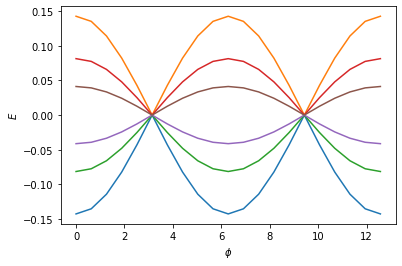

In [613]:
e_array, psi_array = phi_scan()
e_array1, psi_array1 = phi_scan(Bv=1., V_Nv=2.5)
e_array2, psi_array2 = phi_scan(Bv=1., V_Nv=5.)
print(e_array)
plt.plot(np.linspace(0, 4*np.pi, 21), e_array)
plt.plot(np.linspace(0, 4*np.pi, 21), e_array1)
plt.plot(np.linspace(0, 4*np.pi, 21), e_array2)
plt.xlabel(r'$\phi$')
plt.ylabel(r'$E$')

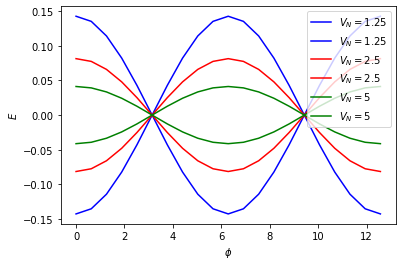

In [620]:
plt.plot(np.linspace(0, 4*np.pi, 21), e_array, color='b', label=r'$V_N=1.25$')
plt.plot(np.linspace(0, 4*np.pi, 21), e_array1, color='r', label=r'$V_N=2.5$')
plt.plot(np.linspace(0, 4*np.pi, 21), e_array2, color='g', label=r'$V_N=5$')
plt.xlabel(r'$\phi$')
plt.ylabel(r'$E$')
plt.legend(loc='upper right')
plt.savefig('Malcolm_1', dpi=300)

[array([-0.05786587,  0.05786587]), array([-0.05562618,  0.05562618]), array([-0.04865184,  0.04865184]), array([-0.03655675,  0.03655675]), array([-0.01973345,  0.01973345]), array([-7.11236625e-17, -7.11236625e-17]), array([-0.01973345,  0.01973345]), array([-0.03655675,  0.03655675]), array([-0.04865184,  0.04865184]), array([-0.05562618,  0.05562618]), array([-0.05786587,  0.05786587]), array([-0.05562618,  0.05562618]), array([-0.04865184,  0.04865184]), array([-0.03655675,  0.03655675]), array([-0.01973345,  0.01973345]), array([-1.80411242e-16, -1.80411242e-16]), array([-0.01973345,  0.01973345]), array([-0.03655675,  0.03655675]), array([-0.04865184,  0.04865184]), array([-0.05562618,  0.05562618]), array([-0.05786587,  0.05786587])]


Text(0, 0.5, '$E$')

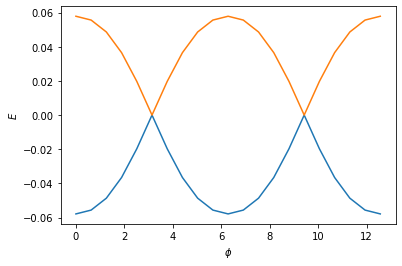

In [656]:
e_array3, psi_array3 = phi_scan(Bv=0.8)
#e_array4, psi_array4 = phi_scan(Bv=0.4, V_Nv=2.5)
#e_array5, psi_array5 = phi_scan(Bv=0.4, V_Nv=5.)
print(e_array3)
plt.plot(np.linspace(0, 4*np.pi, 21), e_array3)
#plt.plot(np.linspace(0, 4*np.pi, 21), e_array4)
#plt.plot(np.linspace(0, 4*np.pi, 21), e_array5)
plt.xlabel(r'$\phi$')
plt.ylabel(r'$E$')

## Explicit Junction (SNS)

In [13]:
def make_system_ex(mu=0.5,
                t=-1., B=1., delta=0.5, alpha_so=0.5, V_N=1.25, phi=0, L=3):
    # Start with an empty tight-binding system. On each site, there
    # are now electron and hole orbitals, so we must specify the
    # number of orbitals per site. The orbital structure is the same
    # as in the Hamiltonian.
    # norbs=4 as per the scipost paper
    lat = kwant.lattice.chain(norbs=4)
    syst = kwant.Builder()
    
    tau_x = np.kron(np.array([[0, 1], [1, 0]]), np.eye(2))
    tau_y = np.kron(np.array([[0, -1j], [1j, 0]]), np.eye(2))
    tau_z = np.kron(np.array([[1, 0], [0, -1]]), np.eye(2))
    sigma_x = np.kron(np.eye(2), np.array([[0, 1], [1, 0]]))
    sigma_y = np.kron(np.eye(2), np.array([[0, -1j], [1j, 0]]))
    sigma_z = np.kron(np.eye(2), np.array([[1, 0], [0, -1]]))

    #### Define the scattering region. ####
    # The superconducting order parameter couples electron and hole orbitals
    # on each site, and hence enters as an onsite potential.
    # The pairing is only included beyond the point 'Deltapos' in the scattering region.
    syst[(lat(0))] = (mu-2.*t)*tau_z + B*sigma_z + delta*tau_x
    syst[(lat(x) for x in range(1, L-1))] = (mu-2.*t+V_N)*tau_z + B*sigma_z
    syst[(lat(L-1))] = (mu-2.*t)*tau_z + B*sigma_z + delta*tau_x

    
    # Hoppings
    syst[(lat(0), lat(1))] = np.matmul(sp.linalg.expm(phi*1j*tau_z), t*tau_z + alpha_so*1j*np.matmul(tau_z, sigma_x))
    syst[(lat(1), lat(2))] = t*tau_z + alpha_so*1j*np.matmul(tau_z, sigma_x)
    #### Define the leads. ####
    sym_left = kwant.TranslationalSymmetry([-a])
    lead0 = kwant.Builder(sym_left)
    lead0[(lat(-1))] = (mu-2.*t)*tau_z + B*sigma_z + delta*tau_x
    lead0[lat.neighbors()] = t*tau_z + alpha_so*1j*np.matmul(tau_z, sigma_x)
    # Right lead - superconducting, so the order parameter is included.
    sym_right = kwant.TranslationalSymmetry([a])
    lead1 = kwant.Builder(sym_right)
    #print((mu-2.*t)*tau_z + B*sigma_z + delta*tau_x)
    #print(complex_round(np.matmul(sp.linalg.expm(phi*1j*tau_z), (mu-2.*t)*tau_z + B*sigma_z + delta*tau_x)))
    lead1[(lat(L))] =  (mu-2.*t)*tau_z + B*sigma_z + delta*tau_x #phi here on delta?
    lead1[lat.neighbors()] = t*tau_z + alpha_so*1j*np.matmul(tau_z, sigma_x)

    #### Attach the leads and return the system. ####
    syst.attach_lead(lead0)
    syst.attach_lead(lead1)

    return syst

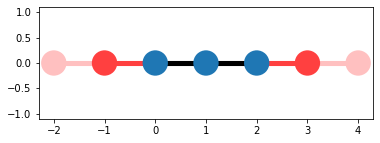

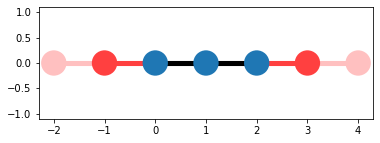

In [14]:
syst4 = make_system_ex(B=0.4, phi=0.*np.pi, t=-0.1)
syst4f = syst4.finalized()
kwant.plot(syst4f)

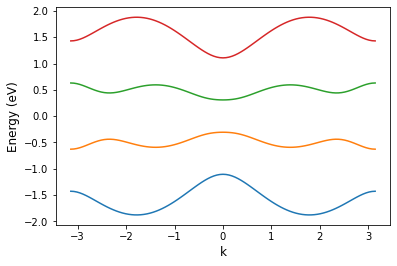

In [15]:
bands=kwant.physics.Bands(syst4f.leads[1])
momenta=np.linspace(-np.pi,np.pi,101)
energies=[bands(k) for k in momenta]

x=np.array(energies)
en=(x)
#plt.ylim(-2.,2)


plt.plot(momenta, en)
plt.ylabel('Energy (eV)', fontsize=12)
plt.xlabel('k', fontsize=12)
plt.show()

In [859]:
energies, wavefunctions = find_boundstates(syst4f, -1., 1., rtol=1e-2)
print(energies, wavefunctions)

[-0.87070466 -0.29242704  0.29242704  0.87070466] [[-1.36047587e-02+8.02289935e-03j -1.56350653e-01+1.72806311e-01j
   4.38267957e-03+3.19101652e-02j  1.15087487e-02-3.68150154e-01j]
 [-8.69491874e-02-1.47443295e-01j  7.36161802e-02+6.66060042e-02j
  -3.98409370e-01+5.47192594e-02j  8.54741675e-03+2.67200952e-04j]
 [-7.36614943e-03+4.34391206e-03j  2.69809440e-01-2.98206454e-01j
   1.35081679e-02+9.83525861e-02j  5.34838305e-03-1.71087934e-01j]
 [ 1.87098856e-01+3.17271186e-01j -2.38845216e-02-2.16100937e-02j
  -2.30872446e-01+3.17090164e-02j -1.57864762e-02-4.93501321e-04j]
 [ 4.49349935e-02-2.64987375e-02j  4.93230392e-17-1.96796147e-17j
  -2.61680750e-02-1.90529009e-01j  9.20537735e-17+2.80704346e-17j]
 [ 3.68515992e-17+1.40092690e-17j -8.58015386e-02-7.76309993e-02j
  -1.17054846e-17+7.82240014e-17j  5.44475454e-01+1.70208572e-02j]
 [-4.69228034e-01+2.76709743e-01j  3.81277816e-17+7.97638155e-17j
  -1.57441148e-02-1.14632451e-01j  1.10821731e-16+1.08061382e-16j]
 [ 3.22533764e-17-1

In [16]:
def phi_scan(Bv=1., V_Nv=1.25, tv=-1):
    energy_arrays = []
    wavefunc_arrays = []
    for i in np.linspace(0, 2*np.pi, 21):
        syst = make_system_ex(phi=i, B=Bv, V_N=V_Nv, t=tv)
        systf = syst.finalized()
        energies, wavefunctions = find_boundstates(systf, -0.5, 0.5, rtol=1e-2)
        energy_arrays.append(energies)
        wavefunc_arrays.append(wavefunctions)
    return energy_arrays, wavefunc_arrays


[array([-0.09671577,  0.09671577]), array([-0.0906275,  0.0906275]), array([-0.07445547,  0.07445547]), array([-0.05212824,  0.05212824]), array([-0.02668997,  0.02668997]), array([5.70724024e-16, 5.70724024e-16]), array([-0.02668997,  0.02668997]), array([-0.05212824,  0.05212824]), array([-0.07445547,  0.07445547]), array([-0.0906275,  0.0906275]), array([-0.09671577,  0.09671577]), array([-0.0906275,  0.0906275]), array([-0.07445547,  0.07445547]), array([-0.05212824,  0.05212824]), array([-0.02668997,  0.02668997]), array([5.66387215e-16, 5.66387215e-16]), array([-0.02668997,  0.02668997]), array([-0.05212824,  0.05212824]), array([-0.07445547,  0.07445547]), array([-0.0906275,  0.0906275]), array([-0.09671577,  0.09671577])]


Text(0, 0.5, '$E$')

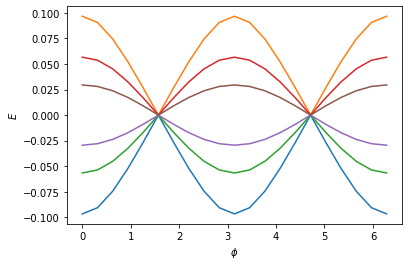

In [731]:
e_array, psi_array = phi_scan()
e_array1, psi_array1 = phi_scan(Bv=1., V_Nv=2.5)
e_array2, psi_array2 = phi_scan(Bv=1., V_Nv=5.)
print(e_array)
plt.plot(np.linspace(0, 2*np.pi, 21), e_array)
plt.plot(np.linspace(0, 2*np.pi, 21), e_array1)
plt.plot(np.linspace(0, 2*np.pi, 21), e_array2)
plt.xlabel(r'$\phi$')
plt.ylabel(r'$E$')

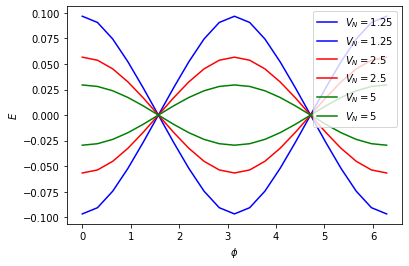

In [749]:
plt.plot(np.linspace(0, 2*np.pi, 21), e_array, color='b', label=r'$V_N=1.25$')
plt.plot(np.linspace(0, 2*np.pi, 21), e_array1, color='r', label=r'$V_N=2.5$')
plt.plot(np.linspace(0, 2*np.pi, 21), e_array2, color='g', label=r'$V_N=5$')
plt.xlabel(r'$\phi$')
plt.ylabel(r'$E$')
plt.legend(loc='upper right')
plt.savefig('Malcolm_2', dpi=300)

[array([-0.29242704,  0.29242704]), array([-0.29088395,  0.29088395]), array([-0.2863633,  0.2863633]), array([-0.2799258,  0.2799258]), array([-0.2741843,  0.2741843]), array([-0.2718963,  0.2718963]), array([-0.2741843,  0.2741843]), array([-0.2799258,  0.2799258]), array([-0.2863633,  0.2863633]), array([-0.29088395,  0.29088395]), array([-0.29242704,  0.29242704]), array([-0.29088395,  0.29088395]), array([-0.2863633,  0.2863633]), array([-0.2799258,  0.2799258]), array([-0.2741843,  0.2741843]), array([-0.2718963,  0.2718963]), array([-0.2741843,  0.2741843]), array([-0.2799258,  0.2799258]), array([-0.2863633,  0.2863633]), array([-0.29088395,  0.29088395]), array([-0.29242704,  0.29242704])]


Text(0, 0.5, '$E$')

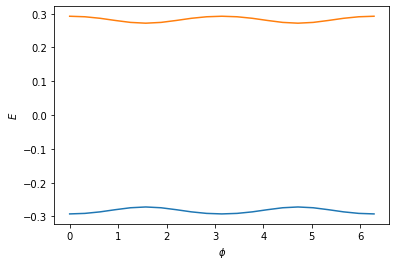

In [860]:
e_array3, psi_array3 = phi_scan(Bv=0.4, tv=-0.1)
#e_array4, psi_array4 = phi_scan(Bv=0.4, V_Nv=2.5)
#e_array5, psi_array5 = phi_scan(Bv=0.4, V_Nv=5.)
print(e_array3)
plt.plot(np.linspace(0, 2*np.pi, 21), e_array3)
#plt.plot(np.linspace(0, 4*np.pi, 21), e_array4)
#plt.plot(np.linspace(0, 4*np.pi, 21), e_array5)
plt.xlabel(r'$\phi$')
plt.ylabel(r'$E$')

ValueError: setting an array element with a sequence.

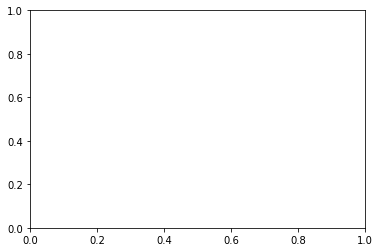

In [862]:
e_array4, psi_array4 = phi_scan(Bv=0.4, V_Nv=2.5, tv=-0.1)
e_array5, psi_array5 = phi_scan(Bv=0.4, V_Nv=5., tv=-0.1)

plt.plot(np.linspace(0, 2*np.pi, 21), e_array4)
plt.plot(np.linspace(0, 2*np.pi, 21), e_array5)

[array([-0.30571006,  0.30571006]), array([-0.30563456,  0.30563456]), array([-0.30541852,  0.30541852]), array([-0.30510575,  0.30510575]), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([-0.30510575,  0.30510575]), array([-0.30541852,  0.30541852]), array([-0.30563456,  0.30563456]), array([-0.30571006,  0.30571006]), array([-0.30563456,  0.30563456]), array([-0.30541852,  0.30541852]), array([-0.30510575,  0.30510575]), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([-0.30510575,  0.30510575]), array([-0.30541852,  0.30541852]), array([-0.30563456,  0.30563456]), array([-0.30571006,  0.30571006])]
[array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array

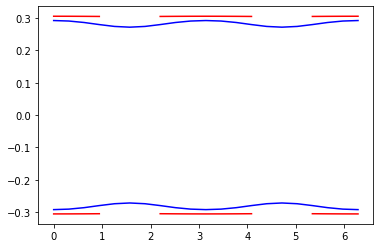

In [887]:
print(e_array4)
print(e_array5)
plt.plot(np.linspace(0, 2*np.pi, 21), e_array3, color='b')
plt.plot(np.linspace(0, 2*np.pi, 21)[0:4], e_array4[0:4], color='r')
plt.plot(np.linspace(0, 2*np.pi, 21)[7:14], e_array4[7:14], color='r')
plt.plot(np.linspace(0, 2*np.pi, 21)[17:21], e_array4[17:21], color='r')

[[-0.30694336  0.30694336]
 [-0.30551769  0.30551769]
 [-0.30372914  0.30372914]
 [-0.3029527   0.3029527 ]
 [-0.30372914  0.30372914]
 [-0.30551769  0.30551769]
 [-0.30694336  0.30694336]] [[-0.30694336  0.30694336]
 [-0.30551769  0.30551769]
 [-0.30372914  0.30372914]
 [-0.3029527   0.3029527 ]
 [-0.30372914  0.30372914]
 [-0.30551769  0.30551769]
 [-0.30694336  0.30694336]]


Text(0, 0.5, '$E$')

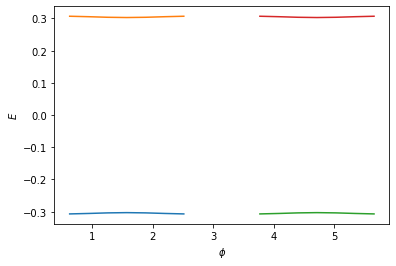

In [847]:
#print(np.array(e_array3)[12:19])
print(np.array(e_array3[2:9]), np.array(e_array3[12:19]))
x = np.linspace(0, 2*np.pi, 21)
x1 = x[2:9]
x2 = x[12:19]
plt.plot(x1, np.array(e_array3[2:9]))
plt.plot(x2, np.array(e_array3[12:19]))
#plt.plot(np.linspace(0, 4*np.pi, 21), e_array4)
#plt.plot(np.linspace(0, 4*np.pi, 21), e_array5)
plt.xlabel(r'$\phi$')
plt.ylabel(r'$E$')

In [915]:
def B_scan(phiv=0., V_Nv=1.25, tv=-1):
    energy_arrays = []
    wavefunc_arrays = []
    for i in np.linspace(0, 1, 21):
        syst = make_system_ex(phi=phiv, B=i, V_N=V_Nv, t=tv)
        systf = syst.finalized()
        energies, wavefunctions = find_boundstates(systf, -1., 1., rtol=1e-2)
        energy_arrays.append(energies)
        wavefunc_arrays.append(wavefunctions)
    return energy_arrays, wavefunc_arrays

In [916]:
Be_array, Bpsi_array = B_scan()
print(Be_array)

[array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([-0.53260317,  0.53260317]), array([-0.49729178,  0.49729178]), array([-0.45414739,  0.45414739]), array([-0.40682885,  0.40682885]), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([-0.02484905,  0.02484905]), array([-0.04748073,  0.04748073]), array([-0.06481062,  0.06481062]), array([-0.07817022,  0.07817022]), array([-0.24270832, -0.08856201,  0.08856201,  0.24270832]), array([-0.27053993, -0.09671577,  0.09671577,  0.27053993])]


Text(0.5, 1.0, '$\\phi=0, \\Delta=0.5$')

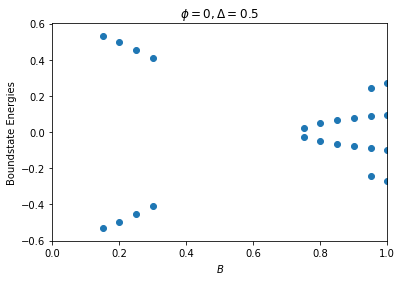

In [917]:
#print(Be_array)
Bex = []
Bey = []
for i in range(len(Be_array)):
    for j in range(len(Be_array[i])):
        Bex.append(i/20.)
        Bey.append(Be_array[i][j])
plt.scatter(Bex, Bey)
plt.xlim(0, 1)
plt.xlabel(r'$B$')
plt.ylabel('Boundstate Energies')
plt.title(r'$\phi=0, \Delta=0.5$')

In [918]:
Be_array1, Bpsi_array1 = B_scan(phiv=0.5*np.pi)
print(Be_array1)

[array([], dtype=float64), array([], dtype=float64), array([-0.55044661,  0.55044661]), array([-0.52463441,  0.52463441]), array([-0.48885468,  0.48885468]), array([-0.44742615,  0.44742615]), array([-0.40268643,  0.40268643]), array([-0.35573588,  0.35573588]), array([-0.30703901,  0.30703901]), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([-2.46330734e-16, -2.46330734e-16]), array([-6.82613688e-16, -6.82613688e-16]), array([-1.60548658e-15, -1.60548658e-15]), array([-1.2490009e-16, -1.2490009e-16]), array([-9.1333191e-16, -9.1333191e-16]), array([3.00107161e-16, 3.00107161e-16])]


Text(0.5, 1.0, '$\\phi=0.5\\pi, \\Delta=0.5$')

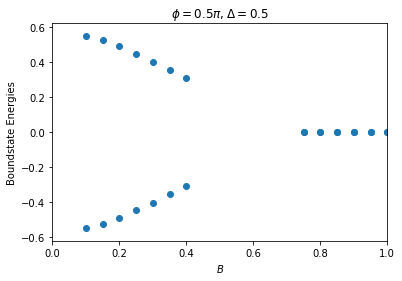

In [919]:
Bex = []
Bey = []
for i in range(len(Be_array1)):
    for j in range(len(Be_array1[i])):
        Bex.append(i/20.)
        Bey.append(Be_array1[i][j])
plt.scatter(Bex, Bey)
plt.xlim(0, 1)
plt.xlabel(r'$B$')
plt.ylabel('Boundstate Energies')
plt.title(r'$\phi=0.5\pi, \Delta=0.5$')

In [920]:
def t_scan(phiv=0., V_Nv=1.25, Bv=0.4):
    energy_arrays = []
    wavefunc_arrays = []
    for i in np.linspace(-1, 1, 21):
        syst = make_system_ex(phi=phiv, B=Bv, V_N=V_Nv, t=i)
        systf = syst.finalized()
        energies, wavefunctions = find_boundstates(systf, -0.6, 0.6, rtol=1e-2)
        energy_arrays.append(energies)
        wavefunc_arrays.append(wavefunctions)
    return energy_arrays, wavefunc_arrays

In [921]:
te_array, tpsi_array = t_scan()
print(te_array)

[array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([-0.30616475,  0.30616475]), array([-0.29242704,  0.29242704]), array([-0.26045424,  0.26045424]), array([], dtype=float64), array([], dtype=float64), array([-0.22934366,  0.22934366]), array([-0.20753284,  0.20753284]), array([-0.19705579,  0.19705579]), array([-0.19344136,  0.19344136]), array([-0.1935172,  0.1935172]), array([-0.19545077,  0.19545077]), array([-0.19821108,  0.19821108]), array([-0.20122843,  0.20122843])]


Text(0.5, 1.0, '$\\phi=0\\pi, \\Delta=0.5, B=0.4, V_N=1.25, \\mu=0.5, \\alpha_{so}=0.5$')

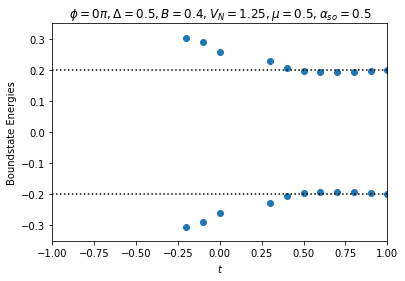

In [941]:
tex = []
tey = []
for i in range(len(te_array)):
    for j in range(len(te_array[i])):
        tex.append(i/10.-1.)
        tey.append(te_array[i][j])
plt.scatter(tex, tey)
plt.axhline(0.2, color='k', linestyle=':')
plt.axhline(-0.2, color='k', linestyle=':')
plt.xlim(-1, 1)
plt.xlabel(r'$t$')
plt.ylabel('Boundstate Energies')
plt.title(r'$\phi=0\pi, \Delta=0.5, B=0.4, V_N=1.25, \mu=0.5, \alpha_{so}=0.5$')

In [933]:
te_array1, tpsi_array1 = t_scan(phiv=0.5*np.pi)
print(te_array1)

[array([-0.30703901,  0.30703901]), array([-0.30677912,  0.30677912]), array([-0.30624809,  0.30624809]), array([-0.30538365,  0.30538365]), array([-0.30420585,  0.30420585]), array([-0.3029527,  0.3029527]), array([-0.30228949,  0.30228949]), array([-0.30336319,  0.30336319]), array([], dtype=float64), array([-0.2718963,  0.2718963]), array([-0.21143624,  0.21143624]), array([], dtype=float64), array([-0.15898359,  0.15898359]), array([-0.22318864,  0.22318864]), array([-0.25935029, -0.16265863,  0.16265863,  0.25935029]), array([-0.28349888, -0.11633397,  0.11633397,  0.28349888]), array([-0.29649006, -0.07972417,  0.07972417,  0.29649006]), array([-0.04937898,  0.04937898]), array([-0.02329313,  0.02329313]), array([0.00030672]), array([-0.02026785,  0.02026785])]


Text(0.5, 1.0, '$\\phi=0.5\\pi, \\Delta=0.5, B=0.4, V_N=1.25, \\mu=0.5, \\alpha_{so}=0.5$')

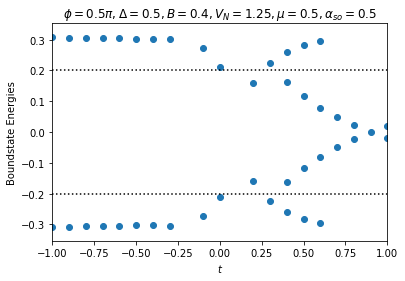

In [942]:
tex = []
tey = []
for i in range(len(te_array1)):
    for j in range(len(te_array1[i])):
        tex.append(i/10.-1.)
        tey.append(te_array1[i][j])
plt.scatter(tex, tey)
plt.axhline(0.2, color='k', linestyle=':')
plt.axhline(-0.2, color='k', linestyle=':')
plt.xlim(-1, 1)
plt.xlabel(r'$t$')
plt.ylabel('Boundstate Energies')
plt.title(r'$\phi=0.5\pi, \Delta=0.5, B=0.4, V_N=1.25, \mu=0.5, \alpha_{so}=0.5$')

In [937]:
te_array2, tpsi_array2 = t_scan(Bv=1.)
print(te_array2)

[array([-0.27053993, -0.09671577,  0.09671577,  0.27053993]), array([-0.27785232, -0.08626887,  0.08626887,  0.27785232]), array([-0.28480819, -0.07258018,  0.07258018,  0.28480819]), array([-0.29054037, -0.0546623 ,  0.0546623 ,  0.29054037]), array([-0.03144084,  0.03144084]), array([0.00223441]), array([-0.03175986,  0.03175986]), array([-0.06337857,  0.06337857]), array([-0.06971637,  0.06971637]), array([-0.0083274,  0.0083274]), array([-0.24324112,  0.24324112]), array([-0.13322025,  0.13322025]), array([-0.02793662,  0.02793662]), array([-0.12473077,  0.12473077]), array([-0.14100651,  0.14100651]), array([-0.25845268,  0.25845268]), array([], dtype=float64), array([-0.26521014,  0.26521014]), array([-0.22326907,  0.22326907]), array([-0.18551432,  0.18551432]), array([-0.15536962,  0.15536962])]


Text(0.5, 1.0, '$\\phi=0\\pi, \\Delta=0.5, B=1, V_N=1.25, \\mu=0.5, \\alpha_{so}=0.5$')

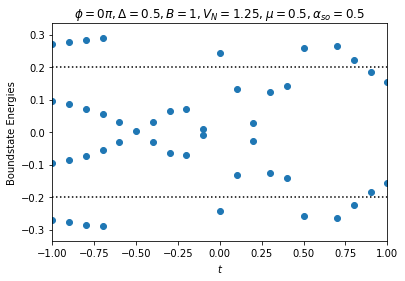

In [943]:
tex = []
tey = []
for i in range(len(te_array2)):
    for j in range(len(te_array2[i])):
        tex.append(i/10.-1.)
        tey.append(te_array2[i][j])
plt.scatter(tex, tey)
plt.axhline(0.2, color='k', linestyle=':')
plt.axhline(-0.2, color='k', linestyle=':')
plt.xlim(-1, 1)
plt.xlabel(r'$t$')
plt.ylabel('Boundstate Energies')
plt.title(r'$\phi=0\pi, \Delta=0.5, B=1, V_N=1.25, \mu=0.5, \alpha_{so}=0.5$')

In [939]:
te_array3, tpsi_array3 = t_scan(Bv=1., phiv=0.5*np.pi)
print(te_array3)

[array([-8.06646416e-16, -8.06646416e-16]), array([-6.11490025e-16, -6.11490025e-16]), array([3.20923843e-17, 3.20923843e-17]), array([1.2490009e-16, 1.2490009e-16]), array([-2.54136989e-16, -2.54136989e-16]), array([-4.94396191e-17, -4.94396191e-17]), array([-3.11382864e-16, -3.11382864e-16]), array([8.62157568e-16, 8.62157568e-16]), array([7.49400542e-16, 7.49400542e-16]), array([7.19910243e-17, 7.19910243e-17]), array([-0.20995893,  0.20995893]), array([-0.12097025,  0.12097025]), array([-0.03500781,  0.03500781]), array([], dtype=float64), array([5.81132364e-16, 5.81132364e-16]), array([1.35308431e-15, 1.35308431e-15]), array([-6.62664368e-16, -6.62664368e-16]), array([1.52135249e-15, 1.52135249e-15]), array([-1.14231541e-15, -1.14231541e-15]), array([8.06646416e-17, 8.06646416e-17]), array([-1.16226473e-16, -1.16226473e-16])]


Text(0.5, 1.0, '$\\phi=0.5\\pi, \\Delta=0.5, B=1, V_N=1.25, \\mu=0.5, \\alpha_{so}=0.5$')

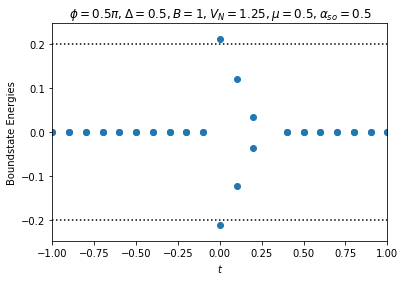

In [944]:
tex = []
tey = []
for i in range(len(te_array3)):
    for j in range(len(te_array3[i])):
        tex.append(i/10.-1.)
        tey.append(te_array3[i][j])
plt.scatter(tex, tey)
plt.axhline(0.2, color='k', linestyle=':')
plt.axhline(-0.2, color='k', linestyle=':')
plt.xlim(-1, 1)
plt.xlabel(r'$t$')
plt.ylabel('Boundstate Energies')
plt.title(r'$\phi=0.5\pi, \Delta=0.5, B=1, V_N=1.25, \mu=0.5, \alpha_{so}=0.5$')

In [945]:
e_array6, psi_array6 = phi_scan(Bv=1., tv=0.7)
print(e_array6)

[array([-0.26521014,  0.26521014]), array([-0.24199548,  0.24199548]), array([-0.19310138,  0.19310138]), array([-0.13319878,  0.13319878]), array([-0.06776965,  0.06776965]), array([6.52256027e-16, 6.52256027e-16]), array([-0.06776965,  0.06776965]), array([-0.13319878,  0.13319878]), array([-0.19310138,  0.19310138]), array([-0.24199548,  0.24199548]), array([-0.26521014,  0.26521014]), array([-0.24199548,  0.24199548]), array([-0.19310138,  0.19310138]), array([-0.13319878,  0.13319878]), array([-0.06776965,  0.06776965]), array([6.4358241e-16, 6.4358241e-16]), array([-0.06776965,  0.06776965]), array([-0.13319878,  0.13319878]), array([-0.19310138,  0.19310138]), array([-0.24199548,  0.24199548]), array([-0.26521014,  0.26521014])]


In [949]:
e_array8, psi_array8 = phi_scan(Bv=1., tv=0.7, V_Nv=2.5)
e_array9, psi_array9 = phi_scan(Bv=1., tv=0.7, V_Nv=5.)
print(e_array8)
print(e_array9)

[array([-0.17236363,  0.17236363]), array([-0.16335258,  0.16335258]), array([-0.13774887,  0.13774887]), array([-0.09908471,  0.09908471]), array([-0.05169892,  0.05169892]), array([3.30464822e-16, 3.30464822e-16]), array([-0.05169892,  0.05169892]), array([-0.09908471,  0.09908471]), array([-0.13774887,  0.13774887]), array([-0.16335258,  0.16335258]), array([-0.17236363,  0.17236363]), array([-0.16335258,  0.16335258]), array([-0.13774887,  0.13774887]), array([-0.09908471,  0.09908471]), array([-0.05169892,  0.05169892]), array([3.13117587e-16, 3.13117587e-16]), array([-0.05169892,  0.05169892]), array([-0.09908471,  0.09908471]), array([-0.13774887,  0.13774887]), array([-0.16335258,  0.16335258]), array([-0.17236363,  0.17236363])]
[array([-0.07057462,  0.07057462]), array([-0.06709484,  0.06709484]), array([-0.05701757,  0.05701757]), array([-0.04137522,  0.04137522]), array([-0.02173096,  0.02173096]), array([-2.35055031e-15, -2.35055031e-15]), array([-0.02173096,  0.02173096])

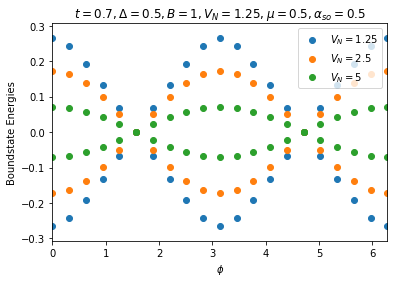

In [951]:
ex = []
ey = []
ex1 = []
ey1 = []
ex2 = []
ey2 = []
for i in range(len(e_array6)):
    for j in range(len(e_array6[i])):
        ex.append(i/10.*np.pi)
        ey.append(e_array6[i][j])
    for j in range(len(e_array8[i])):
        ex1.append(i/10.*np.pi)
        ey1.append(e_array8[i][j])
    for j in range(len(e_array9[i])):
        ex2.append(i/10.*np.pi)
        ey2.append(e_array9[i][j])
plt.scatter(ex, ey, label=r'$V_N=1.25$')
plt.scatter(ex1, ey1, label=r'$V_N=2.5$')
plt.scatter(ex2, ey2, label=r'$V_N=5$')
plt.xlim(0, 2*np.pi)
plt.xlabel(r'$\phi$')
plt.ylabel('Boundstate Energies')
plt.title(r'$t=0.7, \Delta=0.5, B=1, V_N=1.25, \mu=0.5, \alpha_{so}=0.5$')
plt.legend()

In [21]:
e_array7, psi_array7 = phi_scan(Bv=0., tv=0.7, V_Nv=0.)
print(e_array7)
'''e_array10, psi_array10 = phi_scan(Bv=0.4, tv=0.7, V_Nv=2.5)
e_array11, psi_array11 = phi_scan(Bv=0.4, tv=0.7, V_Nv=5.)
print(e_array10)
print(e_array11)'''

[array([-0.40343114, -0.40343114,  0.40343114,  0.40343114]), array([-0.37392139, -0.37392139,  0.37392139,  0.37392139]), array([-0.30629, -0.30629,  0.30629,  0.30629]), array([-0.22216118, -0.22216118,  0.22216118,  0.22216118]), array([-0.1365613, -0.1365613,  0.1365613,  0.1365613]), array([-0.0882013, -0.0882013,  0.0882013,  0.0882013]), array([-0.1365613, -0.1365613,  0.1365613,  0.1365613]), array([-0.22216118, -0.22216118,  0.22216118,  0.22216118]), array([-0.30629, -0.30629,  0.30629,  0.30629]), array([-0.37392139, -0.37392139,  0.37392139,  0.37392139]), array([-0.40343114, -0.40343114,  0.40343114,  0.40343114]), array([-0.37392139, -0.37392139,  0.37392139,  0.37392139]), array([-0.30629, -0.30629,  0.30629,  0.30629]), array([-0.22216118, -0.22216118,  0.22216118,  0.22216118]), array([-0.1365613, -0.1365613,  0.1365613,  0.1365613]), array([-0.0882013, -0.0882013,  0.0882013,  0.0882013]), array([-0.1365613, -0.1365613,  0.1365613,  0.1365613]), array([-0.22216118, -0

'e_array10, psi_array10 = phi_scan(Bv=0.4, tv=0.7, V_Nv=2.5)\ne_array11, psi_array11 = phi_scan(Bv=0.4, tv=0.7, V_Nv=5.)\nprint(e_array10)\nprint(e_array11)'

In [22]:
e_array7

[array([-0.40343114, -0.40343114,  0.40343114,  0.40343114]),
 array([-0.37392139, -0.37392139,  0.37392139,  0.37392139]),
 array([-0.30629, -0.30629,  0.30629,  0.30629]),
 array([-0.22216118, -0.22216118,  0.22216118,  0.22216118]),
 array([-0.1365613, -0.1365613,  0.1365613,  0.1365613]),
 array([-0.0882013, -0.0882013,  0.0882013,  0.0882013]),
 array([-0.1365613, -0.1365613,  0.1365613,  0.1365613]),
 array([-0.22216118, -0.22216118,  0.22216118,  0.22216118]),
 array([-0.30629, -0.30629,  0.30629,  0.30629]),
 array([-0.37392139, -0.37392139,  0.37392139,  0.37392139]),
 array([-0.40343114, -0.40343114,  0.40343114,  0.40343114]),
 array([-0.37392139, -0.37392139,  0.37392139,  0.37392139]),
 array([-0.30629, -0.30629,  0.30629,  0.30629]),
 array([-0.22216118, -0.22216118,  0.22216118,  0.22216118]),
 array([-0.1365613, -0.1365613,  0.1365613,  0.1365613]),
 array([-0.0882013, -0.0882013,  0.0882013,  0.0882013]),
 array([-0.1365613, -0.1365613,  0.1365613,  0.1365613]),
 array

In [952]:
e_array10, psi_array10 = phi_scan(Bv=0.4, tv=0.7, V_Nv=2.5)
e_array11, psi_array11 = phi_scan(Bv=0.4, tv=0.7, V_Nv=5.)
print(e_array10)
print(e_array11)

[array([-0.24985597,  0.24985597]), array([-0.24580778,  0.24580778]), array([-0.2346202,  0.2346202]), array([-0.21988451,  0.21988451]), array([-0.20742178,  0.20742178]), array([-0.20255682,  0.20255682]), array([-0.20742178,  0.20742178]), array([-0.21988451,  0.21988451]), array([-0.2346202,  0.2346202]), array([-0.24580778,  0.24580778]), array([-0.24985597,  0.24985597]), array([-0.24580778,  0.24580778]), array([-0.2346202,  0.2346202]), array([-0.21988451,  0.21988451]), array([-0.20742178,  0.20742178]), array([-0.20255682,  0.20255682]), array([-0.20742178,  0.20742178]), array([-0.21988451,  0.21988451]), array([-0.2346202,  0.2346202]), array([-0.24580778,  0.24580778]), array([-0.24985597,  0.24985597])]
[array([-0.27682556,  0.27682556]), array([-0.27606349,  0.27606349]), array([-0.27394667,  0.27394667]), array([-0.2710925,  0.2710925]), array([-0.26860201,  0.26860201]), array([-0.26761075,  0.26761075]), array([-0.26860201,  0.26860201]), array([-0.2710925,  0.271092

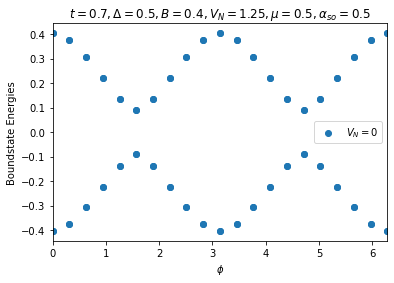

In [23]:
ex = []
ey = []
ex1 = []
ey1 = []
ex2 = []
ey2 = []
for i in range(len(e_array7)):
    for j in range(len(e_array7[i])):
        ex.append(i/10.*np.pi)
        ey.append(e_array7[i][j])
    '''for j in range(len(e_array10[i])):
        ex1.append(i/10.*np.pi)
        ey1.append(e_array10[i][j])
    for j in range(len(e_array11[i])):
        ex2.append(i/10.*np.pi)
        ey2.append(e_array11[i][j])'''
plt.scatter(ex, ey, label=r'$V_N=0.$')
#plt.scatter(ex1, ey1, label=r'$V_N=2.5$')
#plt.scatter(ex2, ey2, label=r'$V_N=5$')
plt.xlim(0, 2*np.pi)
plt.xlabel(r'$\phi$')
plt.ylabel('Boundstate Energies')
plt.title(r'$t=0.7, \Delta=0.5, B=0.4, V_N=1.25, \mu=0.5, \alpha_{so}=0.5$')
plt.legend()